# Show the non linearity of direct problem

## Imports

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import math

# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg import maps

# discretize functionality
from discretize import TensorMesh
from discretize.utils import active_from_xyz

## Parameters

In [445]:
num_electrodes = 48
pixels_between_electrodes = 2
lateral_padding = pixels_between_electrodes * 3

array_dimensions = ((num_electrodes - 1) * pixels_between_electrodes + lateral_padding * 2, (num_electrodes - 1) * pixels_between_electrodes + lateral_padding * 2)
interface_position = 0.5
interface_position = int(interface_position * array_dimensions[0])

print(f"Number of electrodes: {num_electrodes}")
print(f"Array dimensions: {array_dimensions}")
print(f"Interface position: {interface_position}")

Number of electrodes: 48
Array dimensions: (106, 106)
Interface position: 53


## Functions to pass from normalized log space to physical resistivity space and reciprocal

In [446]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return 2 * 10 ** (4 * log_res)
def transform(res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.log10(res / 2) / 4

## Sample creation

In [447]:
uniform_sample: np.ndarray[int, int] = detransform(np.ones(array_dimensions, dtype=float) * 0.5)
above_mean_sample: np.ndarray[int, int] = np.ones(array_dimensions, dtype=float) * 0.5
above_mean_sample[interface_position:] = 0.75
above_mean_sample = detransform(above_mean_sample)
below_mean_sample: np.ndarray[int, int] = np.ones(array_dimensions, dtype=float) * 0.5
below_mean_sample[interface_position:] = 0.25
below_mean_sample = detransform(below_mean_sample)

Plot the samples

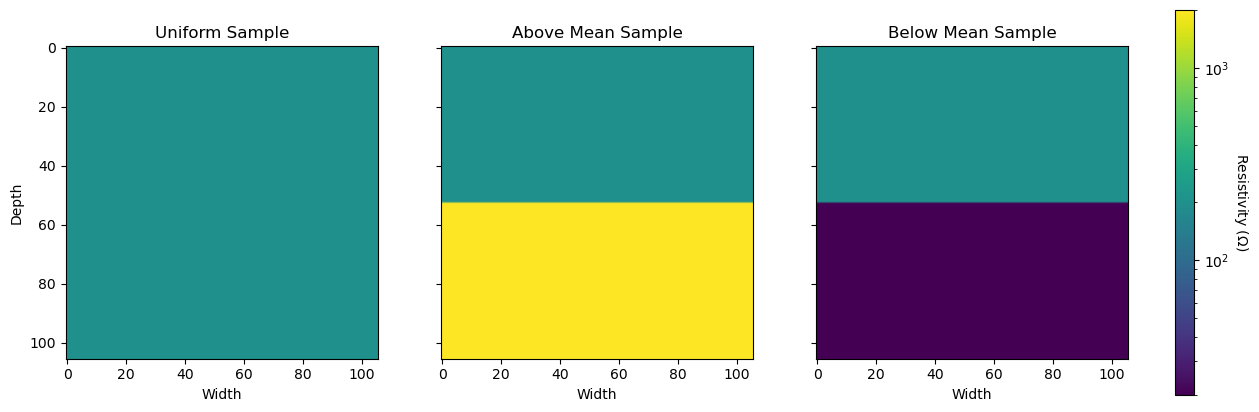

In [448]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

vmin, vmax = np.min([uniform_sample, above_mean_sample, below_mean_sample]), np.max([uniform_sample, above_mean_sample, below_mean_sample])
norm = LogNorm(vmin=vmin, vmax=vmax)

im0 = axs[0].imshow(uniform_sample, cmap='viridis', norm=norm)
axs[0].set_title("Uniform Sample")
axs[0].set_ylabel("Depth")
axs[0].set_xlabel("Width")

im1 = axs[1].imshow(above_mean_sample, cmap='viridis', norm=norm)
axs[1].set_title("Above Mean Sample")
axs[1].set_xlabel("Width")

im2 = axs[2].imshow(below_mean_sample, cmap='viridis', norm=norm)
axs[2].set_title("Below Mean Sample")
axs[2].set_xlabel("Width")

cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.046, pad=0.04, norm=norm)
cbar.set_label(r"Resistivity ($\Omega$)", rotation=270, labelpad=15)

plt.show()

Flatten the samples to be usable for simPEG

In [449]:
uniform_sample_flat = np.flipud(uniform_sample).ravel()
above_mean_sample_flat = np.flipud(above_mean_sample).ravel()
below_mean_sample_flat = np.flipud(below_mean_sample).ravel()

## Create the mesh

In [450]:
hx = [(1, array_dimensions[1])]
hz = [(1, array_dimensions[0])]
# Create the tensor mesh, origin is at the top left corner
mesh = TensorMesh((hx, hz), origin="0N")

Plot it

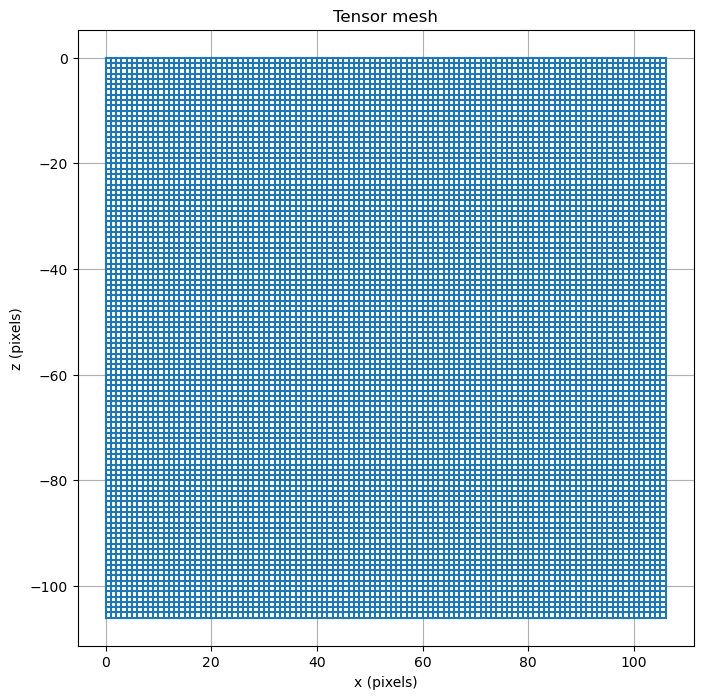

In [451]:
fig, ax = plt.subplots(figsize=(15, 8))
mesh.plot_grid(ax=ax)
ax.set_title("Tensor mesh")
ax.set_xlabel("x (pixels)")
ax.set_ylabel("z (pixels)")
ax.set_aspect('equal')
plt.show()

## Define functions to create the arrays

In [452]:
def schlumberger_array(nbr_electrodes: int,
                       electrode_locations: np.ndarray[np.float64],
                       data_type: str
                       ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, nbr_electrodes // 2):
        locations_a = electrode_locations[:(-2 * a) - 1]
        locations_b = electrode_locations[(2 * a) + 1:]
        locations_m = electrode_locations[a:-a - 1]
        locations_n = electrode_locations[a + 1:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]
        source_list += source_list_a
    return source_list

def wenner_array(nbr_electrodes: int,
                 electrode_locations: np.ndarray[np.float64],
                 data_type: str
                 ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, (nbr_electrodes + 3) // 3 + 1):
        locations_a = electrode_locations[:-3 * a:]
        locations_b = electrode_locations[3 * a:]
        locations_m = electrode_locations[a:-2 * a:]
        locations_n = electrode_locations[2 * a:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]

        source_list += source_list_a
    return source_list

Create the surveys

In [453]:
data_type = "apparent_resistivity"

electrode_locations_x_simPEG = np.linspace(lateral_padding, array_dimensions[1] - lateral_padding, num_electrodes, dtype=float)
electrode_locations_z_simPEG = np.zeros_like(electrode_locations_x_simPEG)
electrode_locations_simPEG = np.c_[electrode_locations_x_simPEG, electrode_locations_z_simPEG]

array = schlumberger_array
# array = wenner_array
source_list = array(num_electrodes, electrode_locations_simPEG, data_type)

survey = dc.Survey(source_list)

Plot the mesh and the electrodes on it

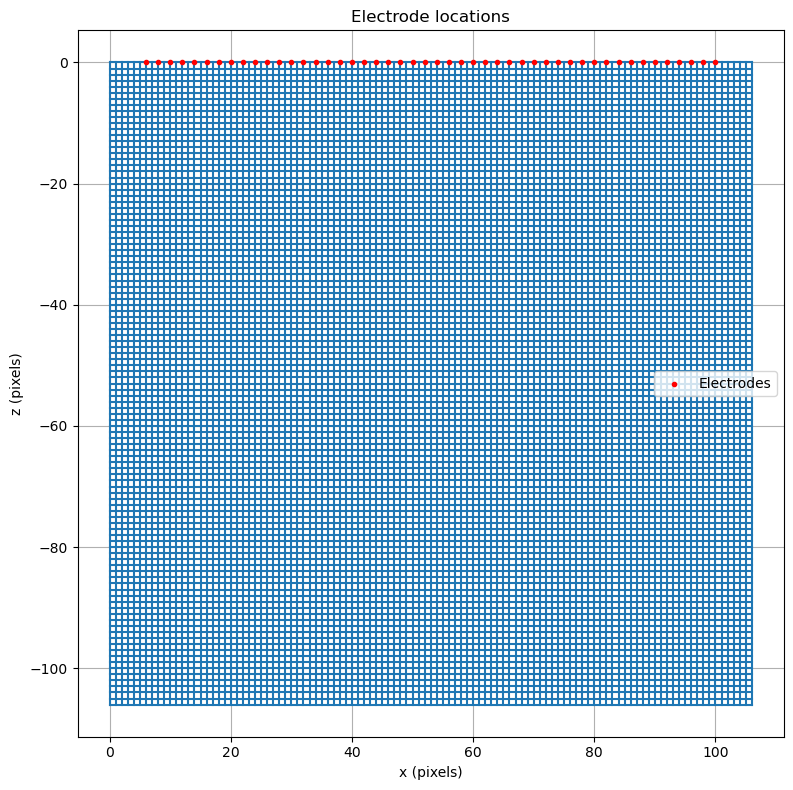

In [454]:
fig, ax = plt.subplots(figsize=(15, 8))
mesh.plot_grid(ax=ax)
ax.scatter(electrode_locations_x_simPEG, electrode_locations_z_simPEG, marker='.', color='red', label='Electrodes', zorder=10)
ax.set_xlabel("x (pixels)")
ax.set_ylabel("z (pixels)")
ax.set_title("Electrode locations")
ax.set_aspect("equal")
ax.legend(loc="center right")
plt.tight_layout()
plt.show()

Create topography

In [404]:
x_topo = np.linspace(0, array_dimensions[1], array_dimensions[1])
z_topo = np.zeros_like(x_topo)
topo_2d = np.c_[x_topo, z_topo]

Create the identity map for resistivity to mesh

In [344]:
identity_map = maps.IdentityMap(mesh, mesh.n_cells)

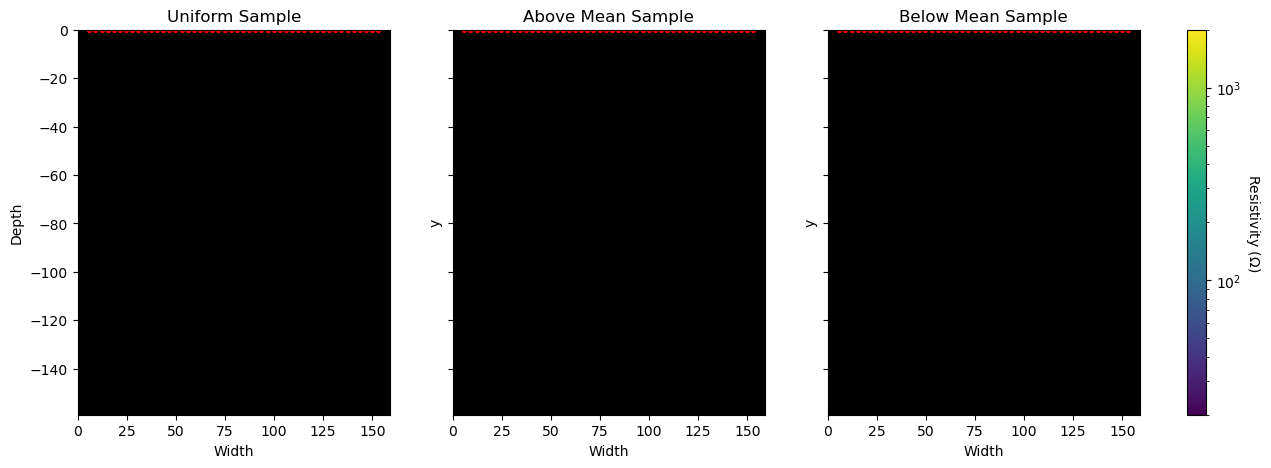

In [345]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

vmin, vmax = np.min([uniform_sample, above_mean_sample, below_mean_sample]), np.max([uniform_sample, above_mean_sample, below_mean_sample])
norm = LogNorm(vmin=vmin, vmax=vmax)

mesh_plot = mesh.plot_image(identity_map * uniform_sample_flat, ax=axs[0], grid=True)
for line in mesh_plot:
    line.set_linewidth(0.01)
mesh_plot[0].set_norm(norm)
axs[0].scatter(electrode_locations_x_simPEG, electrode_locations_z_simPEG, 8, "r", label="Electrodes")
axs[0].set_title("Uniform Sample")
axs[0].set_ylabel("Depth")
axs[0].set_xlabel("Width")

mesh_plot = mesh.plot_image(identity_map * above_mean_sample_flat, ax=axs[1], grid=True)
for line in mesh_plot:
    line.set_linewidth(0.01)
mesh_plot[0].set_norm(norm)
axs[1].scatter(electrode_locations_x_simPEG, electrode_locations_z_simPEG, 8, "r", label="Electrodes")
axs[1].set_title("Above Mean Sample")
axs[1].set_xlabel("Width")

mesh_plot = mesh.plot_image(identity_map * below_mean_sample_flat, ax=axs[2], grid=True)
for line in mesh_plot:
    line.set_linewidth(0.01)
mesh_plot[0].set_norm(norm)
axs[2].scatter(electrode_locations_x_simPEG, electrode_locations_z_simPEG, 8, "r", label="Electrodes")
axs[2].set_title("Below Mean Sample")
axs[2].set_xlabel("Width")

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # Needed for colorbar
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label(r"Resistivity ($\Omega$)", rotation=270, labelpad=15)

plt.show()

Create the simulation

In [346]:
active_cells = active_from_xyz(mesh, topo_2d)
survey.drape_electrodes_on_topography(mesh, active_cells, option="top", topography=topo_2d)
_ = survey.set_geometric_factor()
resistivity_simulation = dc.simulation_2d.Simulation2DNodal(mesh, survey=survey, rhoMap=identity_map)

In [347]:
forward_model_uniform = resistivity_simulation.dpred(uniform_sample_flat)
forward_model_above_mean = resistivity_simulation.dpred(above_mean_sample_flat)
forward_model_below_mean = resistivity_simulation.dpred(below_mean_sample_flat)

/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:762: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:789: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]
/root/miniconda3/envs/simPEG/lib/python3.13/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


## Functions to get pseudo_section

In [348]:
def compute_active_columns(row: int, is_even_row: bool, total_cols: int, offset: int) -> tuple[int, int]:
    """
    Compute the starting and ending column indices for the given row.
    """
    if is_even_row:
        col_start = math.ceil(row * 1.5) - offset
        col_end = total_cols - math.ceil(row * 1.5) + offset
    else:
        col_start = math.ceil((row + 1) * 1.5) - 1 - offset
        col_end = total_cols - math.ceil((row + 1) * 1.5) + 1 + offset
    return col_start, col_end

def process_pseudo_section_wenner_array(rhoa: list[float],
                                        nbr_electrodes: int
                                        ) -> np.ndarray[np.float64]:
    num_rows: int = (nbr_electrodes - 1) // 3
    num_cols: int = nbr_electrodes - 3

    even_num_cols: bool = (num_cols % 2 == 0)
    if even_num_cols:
        # We want non even number of columns to be able to center the
        # triangle.
        num_cols += 1

    offset: int = (nbr_electrodes - 1) % 2

    pseudo_section: np.ndarray[np.float64] = np.empty(
        (num_rows, num_cols), dtype=np.float64)
    pseudo_section.fill(np.nan)
    value_index: int = 0

    for i in range(num_rows):
        # Determine if the current row is considered "even" based on num_cols
        # parity
        is_even_row = (i % 2 == 0) if even_num_cols else (i % 2 == 1)

        col_start, col_end = compute_active_columns(
            i, is_even_row, num_cols, offset)

        for j in range(col_start, col_end):
            # For even rows, use a special average at the center column
            if is_even_row and j == (num_cols - 1) // 2:
                pseudo_section[i, j] = (
                    rhoa[value_index - 1] + rhoa[value_index]) / 2
            else:
                pseudo_section[i, j] = rhoa[value_index]
                value_index += 1
    return pseudo_section

def process_pseudo_section_schlumberger_array(rhoa: list[float],
                                              nbr_electrodes: int
                                              ) -> np.ndarray[np.float64]:
    num_cols: int = nbr_electrodes - 3
    num_lines: int = nbr_electrodes // 2 - 1

    pseudo_section: np.ndarray[np.float64] = np.empty(
        (num_lines, num_cols), dtype=np.float64)
    pseudo_section.fill(np.nan)

    value_index: int = 0
    for i in range(num_lines):
        start_col: int = i
        end_col: int = num_cols - i
        num_values_this_row: int = end_col - start_col
        pseudo_section[i, start_col:end_col] = rhoa[value_index: value_index +
                                                    num_values_this_row]
        value_index += num_values_this_row

    return pseudo_section

Get the pseudosections

In [349]:
if array == wenner_array:
    process_pseudo_section = process_pseudo_section_wenner_array
else:
    process_pseudo_section = process_pseudo_section_schlumberger_array

pseudo_section_uniform = process_pseudo_section(forward_model_uniform, num_electrodes)
pseudo_section_above_mean = process_pseudo_section(forward_model_above_mean, num_electrodes)
pseudo_section_below_mean = process_pseudo_section(forward_model_below_mean, num_electrodes)

Plot them

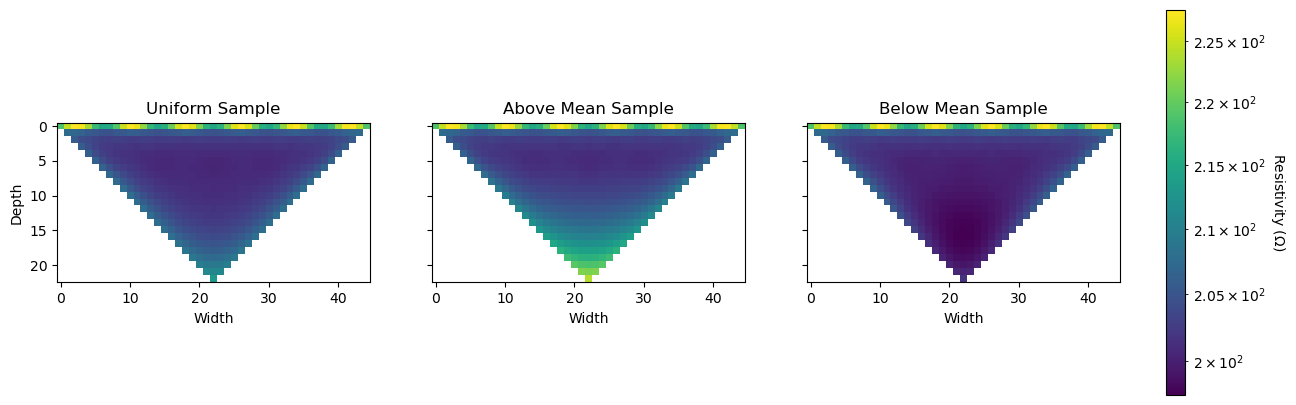

In [350]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

vmin, vmax = np.nanmin([pseudo_section_uniform, pseudo_section_above_mean, pseudo_section_below_mean]), np.nanmax([pseudo_section_uniform, pseudo_section_above_mean, pseudo_section_below_mean])
norm = LogNorm(vmin=vmin, vmax=vmax)

im0 = axs[0].imshow(pseudo_section_uniform, cmap='viridis', norm=norm)
axs[0].set_title("Uniform Sample")
axs[0].set_ylabel("Depth")
axs[0].set_xlabel("Width")

im1 = axs[1].imshow(pseudo_section_above_mean, cmap='viridis', norm=norm)
axs[1].set_title("Above Mean Sample")
axs[1].set_xlabel("Width")

im2 = axs[2].imshow(pseudo_section_below_mean, cmap='viridis', norm=norm)
axs[2].set_title("Below Mean Sample")
axs[2].set_xlabel("Width")

cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.046, pad=0.04, norm=norm)
cbar.set_label(r"Resistivity ($\Omega$)", rotation=270, labelpad=15)

plt.show()

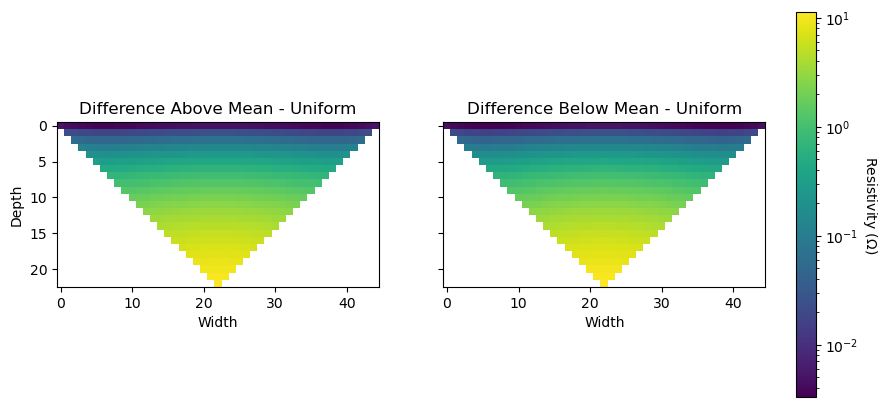

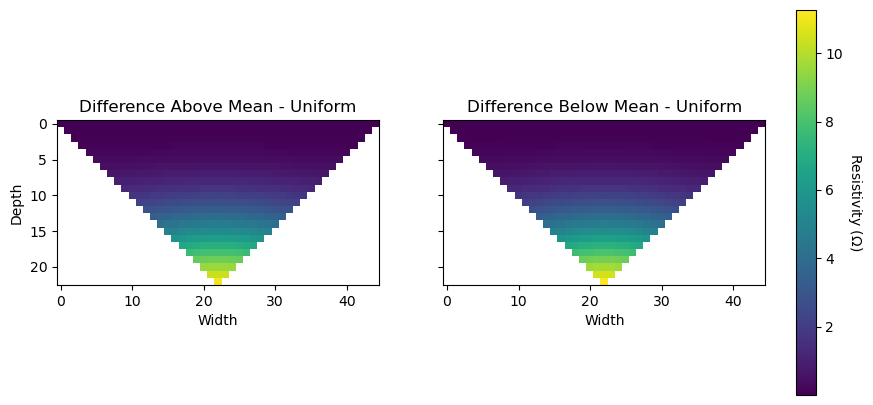

In [351]:
difference_above_mean = np.abs(pseudo_section_above_mean - pseudo_section_uniform)
difference_below_mean = np.abs(pseudo_section_below_mean - pseudo_section_uniform)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

vmin, vmax = np.nanmin([difference_above_mean, difference_below_mean]), np.nanmax([difference_above_mean, difference_below_mean])
norm = LogNorm(vmin=vmin, vmax=vmax)

im0 = axs[0].imshow(difference_above_mean, cmap='viridis', norm=norm)
axs[0].set_title("Difference Above Mean - Uniform")
axs[0].set_ylabel("Depth")
axs[0].set_xlabel("Width")

im1 = axs[1].imshow(difference_below_mean, cmap='viridis', norm=norm)
axs[1].set_title("Difference Below Mean - Uniform")
axs[1].set_xlabel("Width")

cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.046, pad=0.04, norm=norm)
cbar.set_label(r"Resistivity ($\Omega$)", rotation=270, labelpad=15)

plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

vmin, vmax = np.nanmin([difference_above_mean, difference_below_mean]), np.nanmax([difference_above_mean, difference_below_mean])
norm = Normalize(vmin=vmin, vmax=vmax)

im0 = axs[0].imshow(difference_above_mean, cmap='viridis', norm=norm)
axs[0].set_title("Difference Above Mean - Uniform")
axs[0].set_ylabel("Depth")
axs[0].set_xlabel("Width")

im1 = axs[1].imshow(difference_below_mean, cmap='viridis', norm=norm)
axs[1].set_title("Difference Below Mean - Uniform")
axs[1].set_xlabel("Width")

cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.046, pad=0.04, norm=norm)
cbar.set_label(r"Resistivity ($\Omega$)", rotation=270, labelpad=15)

plt.show()

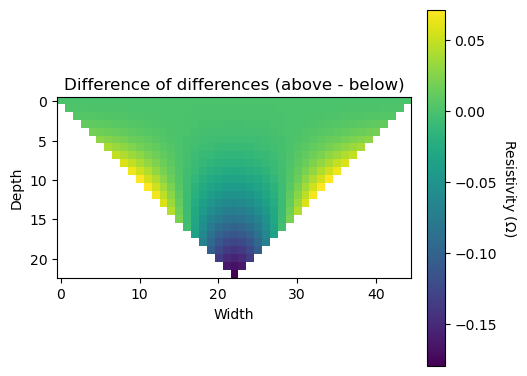

In [352]:
diff_diff = difference_above_mean - difference_below_mean

fig, ax = plt.subplots(figsize=(5, 5))
im0 = ax.imshow(diff_diff, cmap='viridis', norm=Normalize(vmin=np.nanmin(diff_diff), vmax=np.nanmax(diff_diff)))
ax.set_title("Difference of differences (above - below)")
ax.set_ylabel("Depth")
ax.set_xlabel("Width")

cbar = fig.colorbar(im0, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label(r"Resistivity ($\Omega$)", rotation=270, labelpad=15)

plt.show()